In [2]:
# imports
from datasets import load_dataset
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

Load Data

In [4]:
# load train dataset, print number of samples and features
dataset_train = load_dataset('Falah/Alzheimer_MRI', split='train')
dataset_train = dataset_train.to_pandas()
print("Number of examples:", len(dataset_train))
print("Sample data:")
for example in dataset_train[:5]:
    print(example)

Number of examples: 5120
Sample data:
image
label


In [5]:
# load test dataset, print number of samples and features
dataset_test = load_dataset('Falah/Alzheimer_MRI', split='test')
dataset_test = dataset_test.to_pandas()
print("Number of examples:", len(dataset_test))
print("Sample data:")
for example in dataset_test[:5]:
    print(example)

Number of examples: 1280
Sample data:
image
label


In [6]:
# categories
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [9]:
# convert bytes to image values representing intensity of pixels
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

In [13]:
# convert train
dataset_train['img_arr'] = dataset_train['image'].apply(dict_to_image)
dataset_train.drop("image", axis=1, inplace=True)
dataset_train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [14]:
# convert test
dataset_test['img_arr'] = dataset_test['image'].apply(dict_to_image)
dataset_test.drop("image", axis=1, inplace=True)
dataset_test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Normalizations

In [ ]:
# min/max scaling function
# takes in image array to scale, the new min and new max, 0 and 1 in this case
def min_max_scale(image_array, new_min=0, new_max=1):
    # get old scale
    old_min = np.min(image_array)
    old_max = np.max(image_array)
    if old_min == old_max:
        return np.full(image_array.shape, new_min)
    # calculate scaled array
    scaled_array = (image_array - old_min) / (old_max - old_min) * (new_max - new_min) + new_min
    return scaled_array

In [ ]:
# create min/max scaled train data
# create empty df to fill
min_max_dataset_train = pd.DataFrame()
min_max_dataset_train['label'] = dataset_train['label']
min_max_images_train = []
# apply function
for i in dataset_train['img_arr']:
    scaled_image = min_max_scale(i, 0, 1)
    min_max_images_train.append(scaled_image)
min_max_dataset_train['img_arr'] = min_max_images_train  

In [ ]:
# z score standardization
def z_score_standardize(image_array):
    mean = np.mean(image_array)
    std = np.std(image_array)
    if std == 0:
        return np.zeros_like(image_array)
    # create standardized array 
    standardized_array = (image_array - mean) / std
    return standardized_array

In [ ]:
# create z score standardized train dataset
z_score_dataset_train = pd.DataFrame()
z_score_dataset_train['label'] = dataset_train['label']
z_score_images_train = []
# apply function
for i in dataset_train['img_arr']:
    scaled_image = z_score_standardize(i)
    z_score_images_train.append(scaled_image)
z_score_dataset_train['img_arr'] = z_score_images_train

In [23]:

# local contrast normalization
import scipy.ndimage
# kernel_size (int): Size of the local neighborhood window.
# epsilon (float): Small constant to prevent division by zero.
def local_contrast_normalization(image_array, kernel_size=3, epsilon=1e-8):
    image_array = image_array.astype(np.float32)
    # Compute local mean using a uniform filter
    local_mean = scipy.ndimage.uniform_filter(image_array, size=kernel_size, mode='reflect')
    # Compute local variance using a squared filter
    local_sqr_mean = scipy.ndimage.uniform_filter(image_array ** 2, size=kernel_size, mode='reflect')
    local_std = np.sqrt(local_sqr_mean - local_mean ** 2 + epsilon)
    # Normalize the image
    normalized_image = (image_array - local_mean) / local_std
    return normalized_image

In [ ]:
# create local contrast normalization train dataset
local_contrast_dataset_train = pd.DataFrame()
local_contrast_dataset_train['label'] = dataset_train['label']
local_contrast_images_train = []
# apply function
for i in dataset_train['img_arr']:
    scaled_image = local_contrast_normalization(i)
    local_contrast_images_train.append(scaled_image)
local_contrast_dataset_train['img_arr'] = local_contrast_images_train

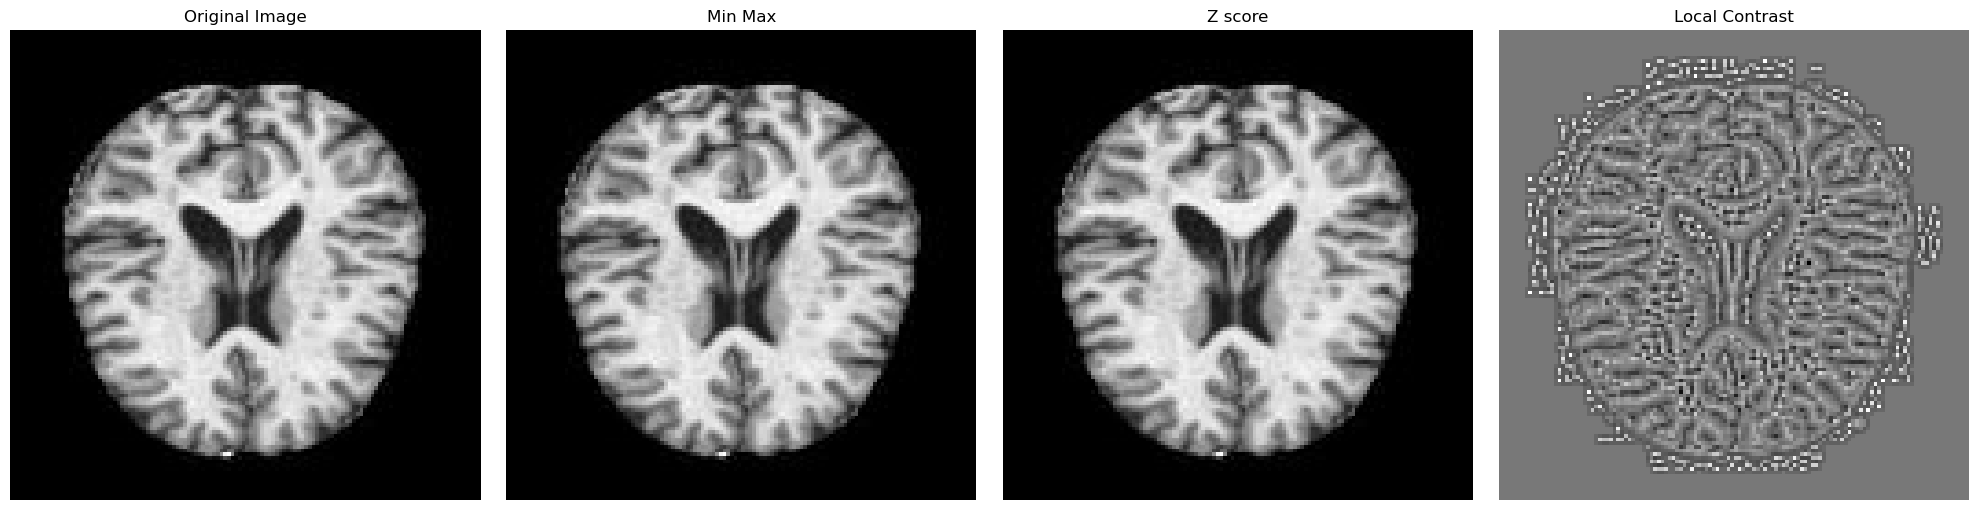

In [25]:
# Show Images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(dataset_train['img_arr'][0], cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(min_max_dataset_train['img_arr'][0], cmap='gray')
axs[1].set_title("Min Max")
axs[1].axis("off")

axs[2].imshow(z_score_dataset_train['img_arr'][0], cmap='gray')
axs[2].set_title("Z score")
axs[2].axis("off")

axs[3].imshow(local_contrast_dataset_train['img_arr'][0], cmap='gray')
axs[3].set_title("Local Contrast")
axs[3].axis("off")

plt.tight_layout()
plt.show()

Cropping

In [27]:
def crop_brain_region(image):
    
    # Threshold the image to separate the brain from the background
    _, thresh = cv2.threshold(image, 10, 255, cv2.THRESH_BINARY_INV)
    
    # Find contours of the non-zero regions (brain region)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        print("failed")
        return image

    # Get the bounding box around the largest contour
    x, y, w, h = cv2.boundingRect(contours[0])
    
    # Optionally draw a rectangle around the brain (for debugging purposes)
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Crop the brain region to eliminate black background
    cropped = image[y:y+h, x:x+w]
    
    return cropped

In [ ]:
# create cropped image train dataset
cropped_dataset_train = pd.DataFrame()
cropped_dataset_train['label'] = dataset_train['label']
cropped_images_train = []
# apply function
for i in dataset_train['img_arr']:
    scaled_image = crop_brain_region(i)
    cropped_images_train.append(scaled_image)
cropped_dataset_train['img_arr'] = cropped_images_train

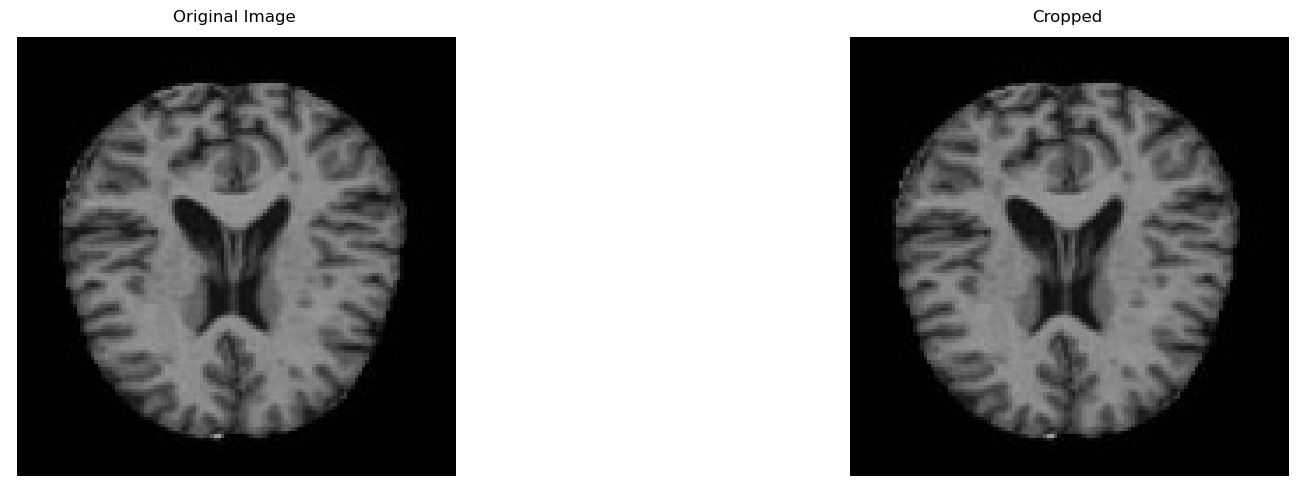

In [31]:
# Show Images
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].imshow(dataset_train['img_arr'][0], cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(cropped_dataset_train['img_arr'][0], cmap='gray')
axs[1].set_title("Cropped")
axs[1].axis("off")

plt.tight_layout()
plt.show()

Noise Reduction

In [ ]:
# Gaussian blur train dataset
gaussian_dataset_train = pd.DataFrame()
gaussian_dataset_train['label'] = dataset_train['label']
gaussian_images_train = []
# apply function
for i in dataset_train['img_arr']:
    # use cv2's Gaussian Blur
    scaled_image = cv2.GaussianBlur(i, (5, 5), 0)
    gaussian_images_train.append(scaled_image)
gaussian_dataset_train['img_arr'] = gaussian_images_train

In [ ]:
# Median blur train dataset
median_dataset_train = pd.DataFrame()
median_dataset_train['label'] = dataset_train['label']
median_images_train = []
# apply function
for i in dataset_train['img_arr']:
    # use cv2s medianBlur
    scaled_image = cv2.medianBlur(i, 5)
    median_images_train.append(scaled_image)
median_dataset_train['img_arr'] = median_images_train

In [ ]:
# Bilateral Filter Train dataset
bilateral_dataset_train = pd.DataFrame()
bilateral_dataset_train['label'] = dataset_train['label']
bilateral_images_train = []
# apply function
for i in dataset_train['img_arr']:
    # use cv2s BilateralFilter
    scaled_image = cv2.bilateralFilter(i, 9, 75, 75)
    bilateral_images_train.append(scaled_image)
bilateral_dataset_train['img_arr'] = bilateral_images_train

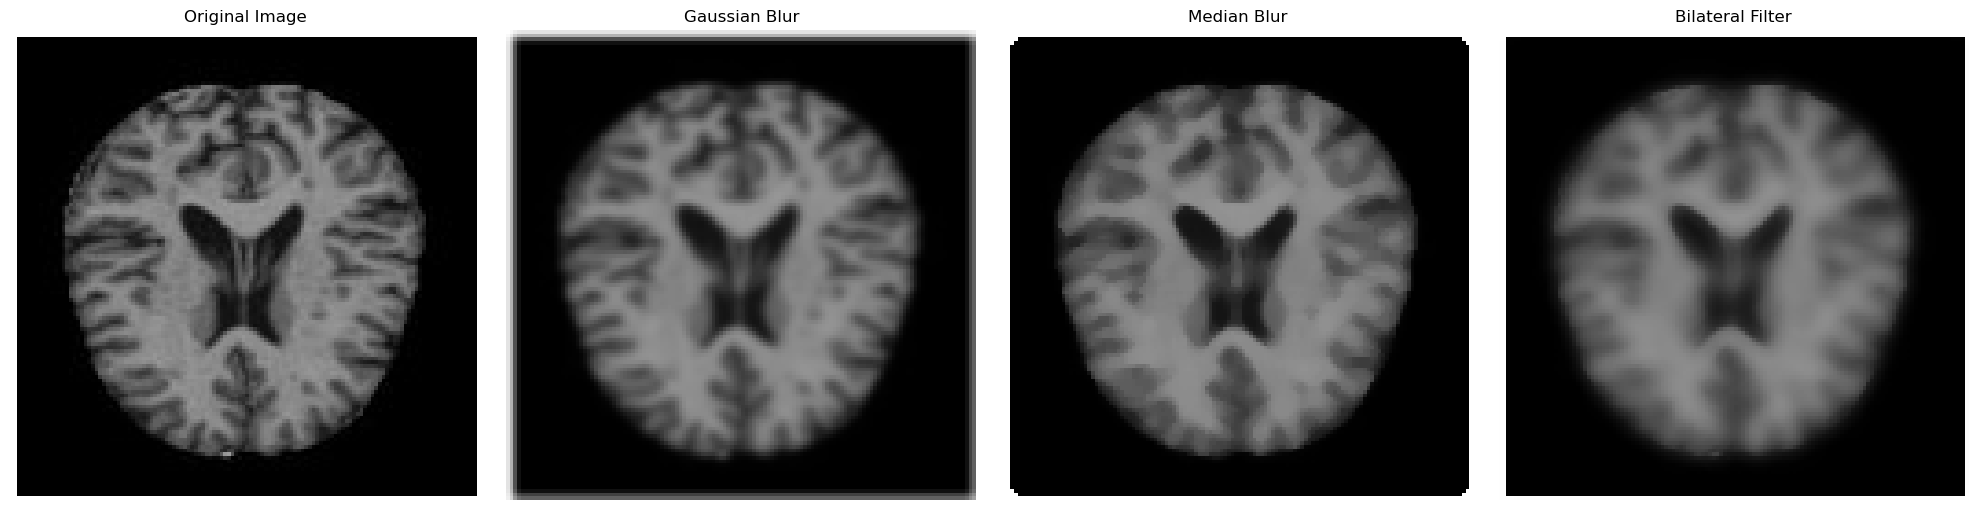

In [37]:
# Show Images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(dataset_train['img_arr'][0], cmap='gray')
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(gaussian_dataset_train['img_arr'][0], cmap='gray')
axs[1].set_title("Gaussian Blur")
axs[1].axis("off")

axs[2].imshow(median_dataset_train['img_arr'][0], cmap='gray')
axs[2].set_title("Median Blur")
axs[2].axis("off")

axs[3].imshow(bilateral_dataset_train['img_arr'][0], cmap='gray')
axs[3].set_title("Bilateral Filter")
axs[3].axis("off")

plt.tight_layout()
plt.show()